# Solving the SWE using NN + FNO

In [253]:
# Load packages
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from scipy.fftpack import fft, ifft
import scipy.io

import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torch.optim as optim

import time

## Load data

In [254]:
# Load a single .mat file
filename = 'dataFNO/data_sigma_no1.mat'
mat_data = scipy.io.loadmat(filename)

# Print the keys of the loaded data
print(mat_data.keys())

# Extract the necessary data (x and h_all) from the loaded data
x_mesh = mat_data['x'].flatten()
h_all = mat_data['h_all'][1:,:]
t_mesh = mat_data['time_all'].flatten()

h_all.shape
sigma = mat_data['sigma'][0,0]

print('sigma:', sigma)


dict_keys(['__header__', '__version__', '__globals__', 'h0', 'h_all', 'sigma', 'time_all', 'u_all', 'x'])
sigma: 0.1


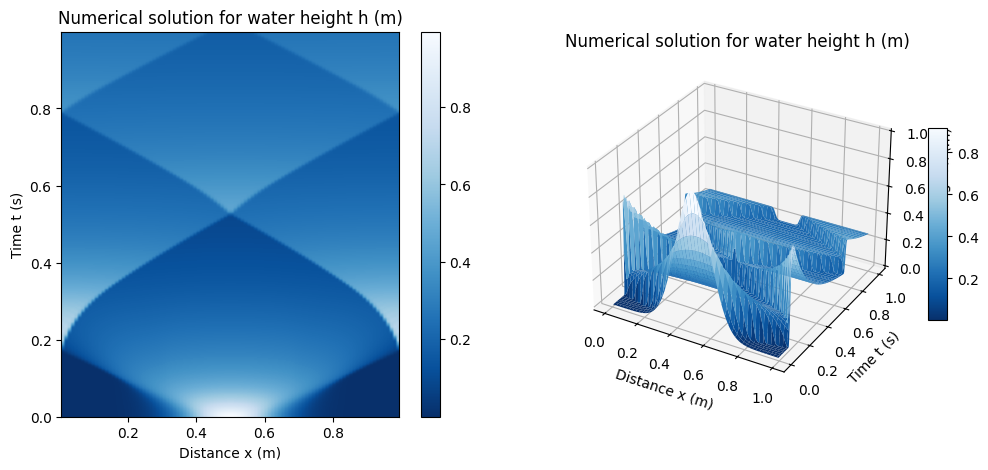

In [255]:
save = 0

cmap = 'Blues_r'

# Plot the data in x,t space
fig = plt.figure(figsize=(12, 5))

ax0 = fig.add_subplot(121)
img = ax0.imshow(h_all, extent=[x_mesh[0], x_mesh[-1], t_mesh[-1], t_mesh[0]], aspect='auto', cmap=cmap)
plt.colorbar(img, ax=ax0)
ax0.set_title('Numerical solution for water height h (m)')
ax0.set_xlabel('Distance x (m)')
ax0.set_ylabel('Time t (s)')
ax0.invert_yaxis()

# Plot in 3D
X, T = np.meshgrid(x_mesh, t_mesh)
ax1 = fig.add_subplot(122, projection='3d')
surf1 = ax1.plot_surface(X, T, h_all, cmap=cmap)
ax1.set_title('Numerical solution for water height h (m)')
ax1.set_xlabel('Distance x (m)')
ax1.set_ylabel('Time t (s)')
ax1.set_zlabel('Water height h (m)')
fig.colorbar(surf1, ax=ax1, shrink = 0.5, aspect=10)

if save:
    plt.savefig('plots/NN_initial.pdf', format='pdf')

plt.show()


### Function: prepare_data

In [256]:
def prepare_data(h_all, p_train, p_val):

    timesteps, _ = h_all.shape

    # Input a
    a = h_all[:-1]

    # Target u
    u = h_all[1:]

    # Split data into training, validation and test sets
    n_train = int(p_train * timesteps)
    n_val = int(p_val * timesteps)
    n_test = timesteps - n_train - n_val

    print(f"n_train = {n_train}, n_val = {n_val}, n_test = {n_test}")

    # Define input and target training sets, validation sets and test sets
    train_x = torch.tensor(a[:n_train], dtype=torch.float32)
    train_y = torch.tensor(u[:n_train], dtype=torch.float32)

    val_x = torch.tensor(a[n_train:n_train + n_val], dtype=torch.float32)
    val_y = torch.tensor(u[n_train:n_train + n_val], dtype=torch.float32)

    test_x = torch.tensor(a[-n_test:], dtype=torch.float32)
    test_y = torch.tensor(u[-n_test:], dtype=torch.float32)

    x = torch.tensor(a, dtype=torch.float32)
    y = torch.tensor(u, dtype=torch.float32)

    #print(train_x.shape, train_y.shape, val_x.shape, val_y.shape, test_x.shape, test_y.shape)

    return n_train, n_val, n_test, x, y, train_x, train_y, val_x, val_y, test_x, test_y


In [257]:
# Define percentage of data to use for training, validation, and testing
p_train = 0.6
p_val = 0.2

n_train, n_val, n_test, x, y, train_x, train_y, val_x, val_y, test_x, test_y = prepare_data(h_all, p_train, p_val)

n_train = 182, n_val = 60, n_test = 62


In [258]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


## Solve the SWE using NN

### (i) FNN

In [259]:
in_features = 100
hidden1 = 128
hidden2 = 128
hidden3 = 64
out_features = 100

model = nn.Sequential(
    nn.Linear(in_features, hidden1),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(hidden1, hidden2),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(hidden2, hidden3),
    nn.Linear(hidden3, out_features),
    nn.Sigmoid()
)

print(model)

Sequential(
  (0): Linear(in_features=100, out_features=128, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.2, inplace=False)
  (3): Linear(in_features=128, out_features=128, bias=True)
  (4): ReLU()
  (5): Dropout(p=0.2, inplace=False)
  (6): Linear(in_features=128, out_features=64, bias=True)
  (7): Linear(in_features=64, out_features=100, bias=True)
  (8): Sigmoid()
)


In [260]:
# Define percentage of data to use for training, validation, and testing
p_train = 0.6
p_val = 0.2

n_train, n_val, n_test, x, y, train_x, train_y, val_x, val_y, test_x, test_y = prepare_data(h_all, p_train, p_val)

dataset = torch.utils.data.TensorDataset(train_x, train_y)
train_loader = DataLoader(dataset, batch_size=32, shuffle=True)

n_train = 182, n_val = 60, n_test = 62


In [261]:
# Loss and optimizer
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

loss_train = []
loss_val = []

# Training loop
n_epochs = 100

for epoch in range(n_epochs):
    for batch_X, batch_y in train_loader:
        # Forward pass
        predictions = model(batch_X)
        loss = loss_fn(predictions, batch_y)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        with torch.no_grad():
            val_loss = loss_fn(model(val_x), val_y)

    # Average epoch loss
    loss /= len(dataset)
    val_loss /= len(dataset)

    # Append losses
    loss_train.append(loss.item())
    loss_val.append(val_loss.item())

    # Print loss every 10 epochs
    if epoch % 10 == 9:
        print(f"Epoch {epoch+1}/{n_epochs}, Loss: {loss.item():.7f}")


Epoch 10/100, Loss: 0.0000473
Epoch 20/100, Loss: 0.0000342
Epoch 30/100, Loss: 0.0000281
Epoch 40/100, Loss: 0.0000170
Epoch 50/100, Loss: 0.0000178
Epoch 60/100, Loss: 0.0000145
Epoch 70/100, Loss: 0.0000143
Epoch 80/100, Loss: 0.0000128
Epoch 90/100, Loss: 0.0000149
Epoch 100/100, Loss: 0.0000133


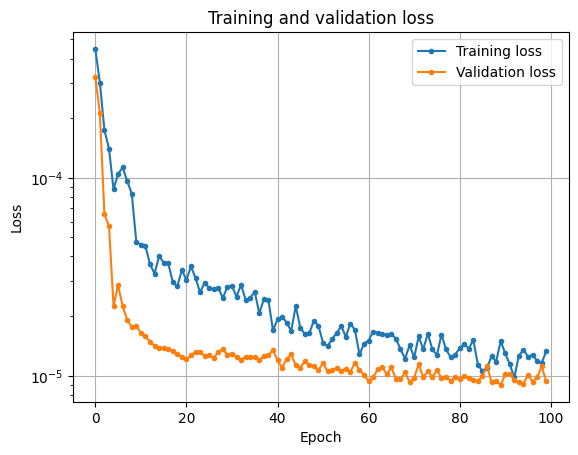

In [262]:
# Plot loss
plt.semilogy(loss_train, '.-', label='Training loss')
plt.semilogy(loss_val, '.-', label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and validation loss')
plt.legend()
plt.grid()
plt.show()


C:\Users\Matteo\AppData\Local\Temp\ipykernel_12228\301331998.py:18: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  plt.imshow(np.abs(y - predictions.detach().numpy()))


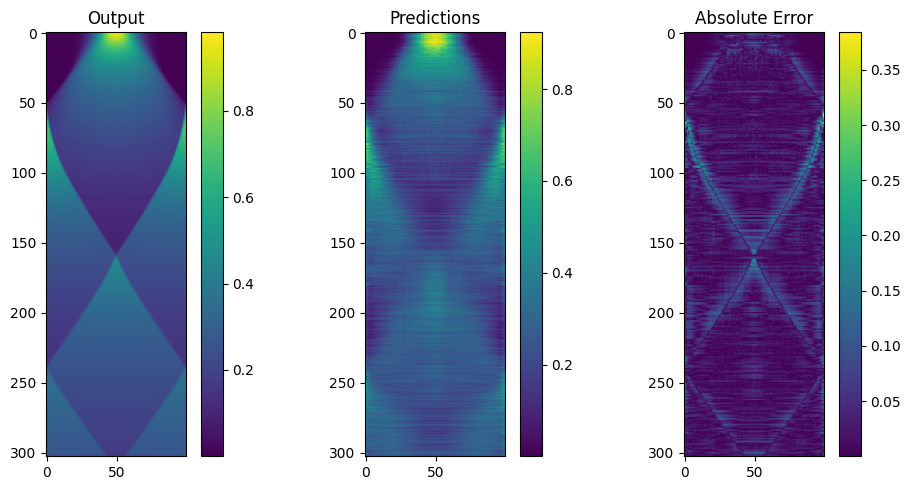

In [263]:
# Compute predictions
predictions = model(x)

# Plot the input, output, and predictions
plt.figure(figsize=(10, 5))

plt.subplot(1, 3, 1)
plt.imshow(y)
plt.colorbar()
plt.title('Output')

plt.subplot(1, 3, 2)
plt.imshow(predictions.detach().numpy())
plt.colorbar()
plt.title('Predictions')

plt.subplot(1, 3, 3)
plt.imshow(np.abs(y - predictions.detach().numpy()))
plt.colorbar()
plt.title('Absolute Error')

plt.tight_layout()

plt.show()


### (ii) RNN Flowmap

In [ ]:
save = 0

In [265]:
# Define model
class RNNFlowmap(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=4, dropout=0.2):
        super(RNNFlowmap, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, num_layers=num_layers, dropout=dropout, batch_first=True)
        self.fc = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, output_size)
        )

    def forward(self, x):
        out, _ = self.rnn(x)
        out = self.fc(out[:, -1, :])  # Use the last hidden state for prediction
        return out
    
input_size = 100
hidden_size = 128
output_size = 100

# Instantiate the model
model = RNNFlowmap(input_size, hidden_size, output_size)
print(model)

RNNFlowmap(
  (rnn): RNN(100, 128, num_layers=4, batch_first=True, dropout=0.2)
  (fc): Sequential(
    (0): Linear(in_features=128, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=100, bias=True)
  )
)


In [266]:
# Prepare data in sequences
def prepare_data_sequences(x, y, seq_length):
    timesteps, spatial_steps = x.shape

    # Number of sequences
    n_sequences = timesteps - seq_length

    # Prepare input and target sequences
    x_seq = torch.zeros((n_sequences, seq_length, spatial_steps))
    y_seq = torch.zeros((n_sequences, spatial_steps))

    for i in range(n_sequences):
        x_seq[i] = x[i:i + seq_length]
        y_seq[i] = y[i + seq_length]
    
    return x_seq, y_seq

# Define percentage of data to use for training, validation, and testing
p_train = 0.7
p_val = 0.2

n_train, n_val, n_test, x, y, train_x, train_y, val_x, val_y, test_x, test_y = prepare_data(h_all, p_train, p_val)

dataset = torch.utils.data.TensorDataset(train_x, train_y)
train_loader = DataLoader(dataset, batch_size=32, shuffle=True)

seq_length = 10

X_input, X_output = prepare_data_sequences(train_x, train_y, seq_length)
print(X_input.shape, X_output.shape)
X_input_val, X_output_val = prepare_data_sequences(val_x, val_y, seq_length)

batch_size = 32

# Create a dataloader for training and validation data
train_dataset = torch.utils.data.TensorDataset(X_input, X_output)
train_loader = DataLoader(train_dataset, batch_size, shuffle=True)

val_dataset = torch.utils.data.TensorDataset(X_input_val, X_output_val)
val_loader = DataLoader(val_dataset, batch_size, shuffle=False)


n_train = 212, n_val = 60, n_test = 32
torch.Size([202, 10, 100]) torch.Size([202, 100])


In [267]:
# Loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

loss_train = []
loss_val = []

# Time training
start_time = time.time()

# Training loop
n_epochs = 500
for epoch in range(n_epochs):
    model.train()  # Set model to training mode
    epoch_train_loss = 0.0  # Track loss for the epoch
    
    for batch_X, batch_y in train_loader:
        # Forward pass
        predictions = model(batch_X)  # Shape: (batch_size, output_size)
        loss = criterion(predictions, batch_y)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Accumulate loss
        epoch_train_loss += loss.item() * batch_X.size(0)  # Multiply by batch size for total loss

        # Validation loss
        # with torch.no_grad():  # Disable gradient computation for validation
        #    val_loss = criterion(model(X_input_val), X_output_val)
         #   val_loss += val_loss.item() * X_input_val.size(0)

    # Validation loss
    model.eval()  # Set model to evaluation mode
    epoch_val_loss = 0.0
    with torch.no_grad():  # Disable gradient computation for validation
        for val_X, val_y in val_loader:
            val_predictions = model(val_X)
            val_loss = criterion(val_predictions, val_y)
            epoch_val_loss += val_loss.item() * val_X.size(0)

    # Average losses
    epoch_train_loss /= len(train_dataset)
    epoch_val_loss /= len(val_dataset)

    # Append losses
    loss_train.append(epoch_train_loss)
    loss_val.append(epoch_val_loss)

    # Print epoch loss
    if epoch % 10 == 9:
        print(f"Epoch {epoch + 1}/{n_epochs}, Training loss: {epoch_train_loss:.6f}, Validation loss: {epoch_val_loss:.6f}")

# Time training
end_time = time.time()
print(f"Training time: {end_time - start_time:.2f}s")

Epoch 10/500, Training loss: 0.004054, Validation loss: 0.001145
Epoch 20/500, Training loss: 0.002040, Validation loss: 0.001338
Epoch 30/500, Training loss: 0.001519, Validation loss: 0.000765
Epoch 40/500, Training loss: 0.001259, Validation loss: 0.000644
Epoch 50/500, Training loss: 0.000945, Validation loss: 0.000557
Epoch 60/500, Training loss: 0.000796, Validation loss: 0.000597
Epoch 70/500, Training loss: 0.000780, Validation loss: 0.000824
Epoch 80/500, Training loss: 0.000777, Validation loss: 0.000706
Epoch 90/500, Training loss: 0.000581, Validation loss: 0.000631
Epoch 100/500, Training loss: 0.000567, Validation loss: 0.000723
Epoch 110/500, Training loss: 0.000497, Validation loss: 0.000673
Epoch 120/500, Training loss: 0.000541, Validation loss: 0.000915
Epoch 130/500, Training loss: 0.000533, Validation loss: 0.000768
Epoch 140/500, Training loss: 0.000418, Validation loss: 0.000824
Epoch 150/500, Training loss: 0.000384, Validation loss: 0.000742
Epoch 160/500, Trai

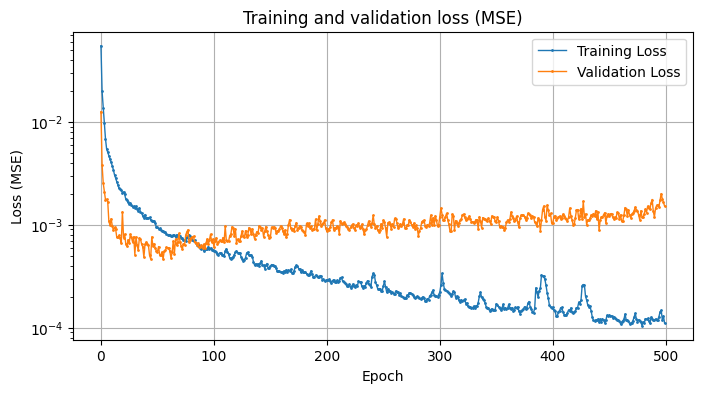

In [279]:
# Plot loss
plt.figure(figsize=(8, 4))
plt.semilogy(loss_train, '.-', label='Training Loss', linewidth=1, markersize=2)
plt.semilogy(loss_val, '.-', label='Validation Loss', linewidth=1, markersize=2)
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Training and validation loss (MSE)')
plt.legend()
plt.grid()

if save:
    plt.savefig('plots/NN_loss_train_val.pdf', format='pdf')

plt.show()

In [269]:
X_all, Y_all = prepare_data_sequences(x, y, seq_length=10)

# Predictions
model.eval()  # Set to evaluation mode
with torch.no_grad():  # Disable gradient computation 
    predictions = model(X_all)  # Full dataset
    test_loss = loss_fn(predictions, Y_all)
    print(f"Loss: {test_loss.item():.2e}")

Loss: 4.09e-04


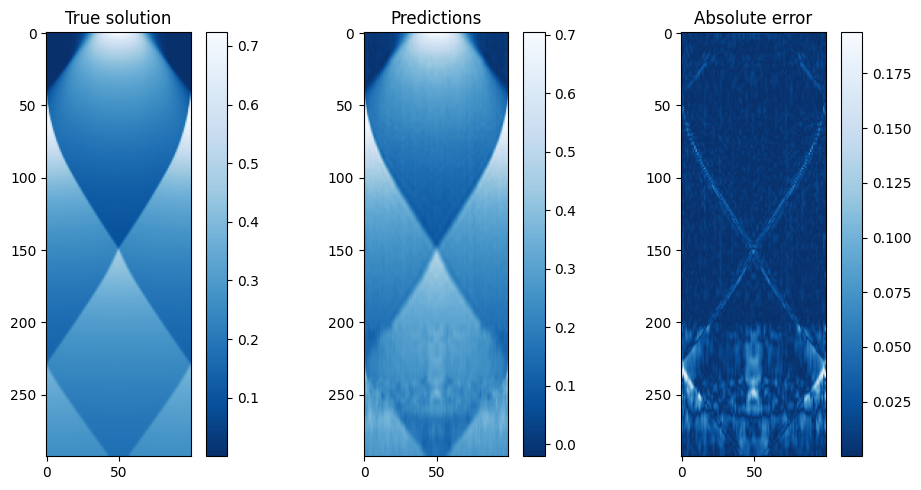

In [270]:
# Plot the output, predictions and absolute error
plt.figure(figsize=(10, 5))

plt.subplot(1, 3, 1)
plt.imshow(Y_all.numpy(), cmap=cmap)
plt.colorbar()
plt.title('True solution')

plt.subplot(1, 3, 2)
plt.imshow(predictions.numpy(), cmap=cmap)
plt.colorbar()
plt.title('Predictions')

plt.subplot(1, 3, 3)
plt.imshow(np.abs(Y_all.numpy() - predictions.numpy()), cmap=cmap)
plt.colorbar()
plt.title('Absolute error')

plt.tight_layout()

plt.show()

In [271]:
T.shape
Y_all.shape

torch.Size([293, 100])

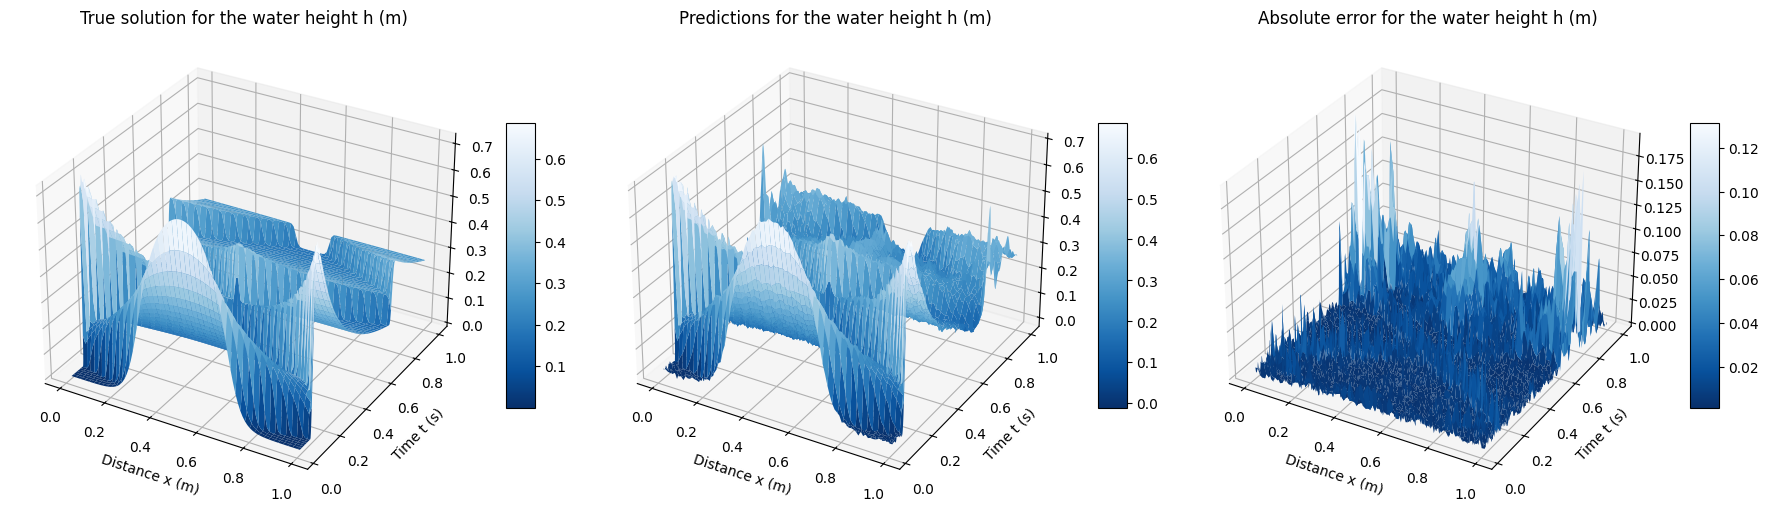

In [272]:
# Prepare grid
X, T = np.meshgrid(x_mesh, t_mesh[seq_length+1:])

# Plot the output, predictions and absolute error
fig = plt.figure(figsize=(18, 6))

cmap = 'Blues_r'

# Plot in 3d
ax1 = fig.add_subplot(131, projection='3d')
surf1 = ax1.plot_surface(X, T, Y_all.numpy(), cmap=cmap)
ax1.set_title('True solution for the water height h (m)')
ax1.set_xlabel('Distance x (m)')
ax1.set_ylabel('Time t (s)')
fig.colorbar(surf1, ax=ax1, shrink = 0.5, aspect=10)

ax2 = fig.add_subplot(132, projection='3d')
surf2 = ax2.plot_surface(X, T, predictions.numpy(), cmap=cmap)
ax2.set_title('Predictions for the water height h (m)')
ax2.set_xlabel('Distance x (m)')
ax2.set_ylabel('Time t (s)')
fig.colorbar(surf2, ax=ax2, shrink = 0.5, aspect=10)

ax3 = fig.add_subplot(133, projection='3d')
surf3 = ax3.plot_surface(X, T, np.abs(Y_all.numpy() - predictions.numpy()), cmap=cmap)
ax3.set_title('Absolute error for the water height h (m)')
ax3.set_xlabel('Distance x (m)')
ax3.set_ylabel('Time t (s)')
fig.colorbar(surf3, ax=ax3, shrink = 0.5, aspect=10)

plt.tight_layout()

if save:
    plt.savefig('plots/NN_predictions.pdf', format='pdf')

plt.show()

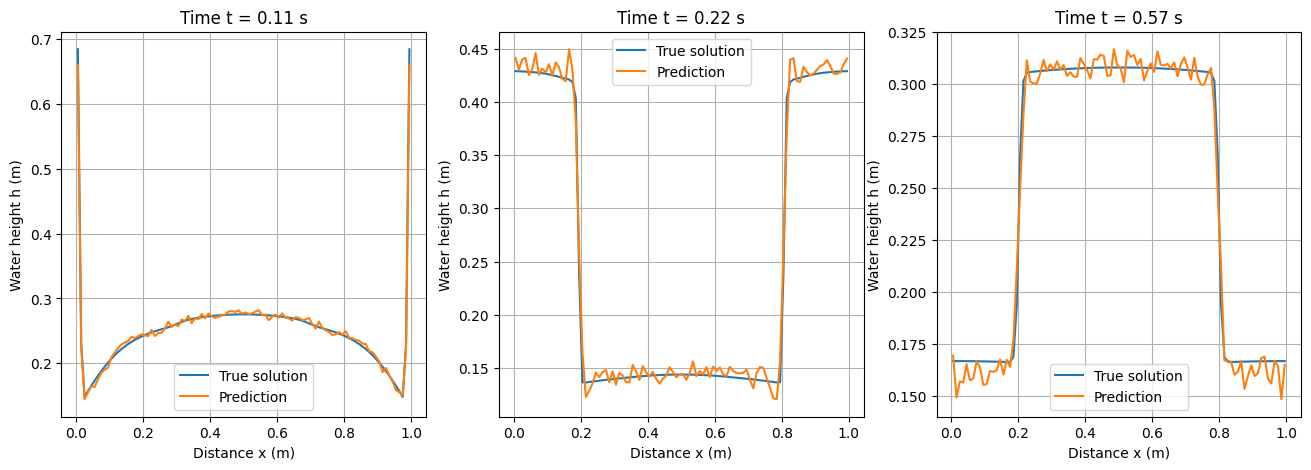

In [273]:
# Plot for some given time steps
indices = [50, 100, 200]

# Create a figure with subplots
fig, axes = plt.subplots(nrows=1, ncols=len(indices), figsize=(16, 5))

for i, idx in enumerate(indices):
    ax = axes[i]
    ax.plot(x_mesh, Y_all[idx].numpy(), label='True solution')
    ax.plot(x_mesh, predictions[idx].numpy(), label='Prediction')
    ax.set_title(f"Time t = {t_mesh[idx]:.2f} s")
    ax.set_xlabel('Distance x (m)')
    ax.set_ylabel('Water height h (m)')
    ax.grid()
    ax.legend()

if save:
    plt.savefig('plots/NN_predictions_time_steps.pdf', format='pdf')

plt.show()

In [274]:
Y_all.shape
predictions.shape

torch.Size([293, 100])

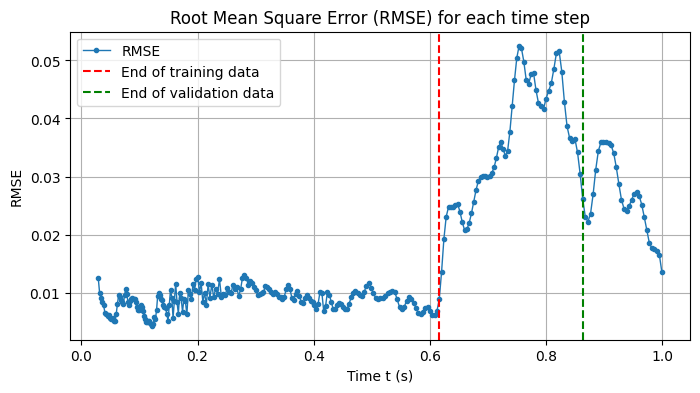

In [275]:
# Plot the RMSE for each time step
rmse = torch.sqrt(torch.mean((Y_all - predictions)**2, dim=1))

plt.figure(figsize=(8, 4))
plt.plot(t_mesh[seq_length+1:], rmse.numpy(),'.-', label='RMSE', linewidth=1)
plt.xlabel('Time t (s)')
plt.ylabel('RMSE')
plt.title('Root Mean Square Error (RMSE) for each time step')
plt.grid()
plt.axvline(x=t_mesh[n_train], color='r', linestyle='--', label='End of training data')
plt.axvline(x=t_mesh[n_train+n_val], color='g', linestyle='--', label='End of validation data')
plt.legend()

if save:
    plt.savefig('plots/NN_RMSE.pdf', format='pdf')

plt.show()


### (iii) LSTM (Long short-term memory)

In [276]:
# LSTM class neural network
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=4, dropout=0.2):
        super(LSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=num_layers, dropout=dropout, batch_first=True)
        self.fc = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, output_size)
        )

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out

input_size = 100
hidden_size = 128
output_size = 100

# Define model
model = LSTM(input_size, hidden_size, output_size)
print(model)

LSTM(
  (lstm): LSTM(100, 128, num_layers=4, batch_first=True, dropout=0.2)
  (fc): Sequential(
    (0): Linear(in_features=128, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=100, bias=True)
  )
)


In [277]:
# Define sequence length
sequence_length = 5
num_sequences = 243 - sequence_length
X = h_train.copy()
batch_size = 32

# Create input-output pairs
X_input = []
X_output = []

for i in range(num_sequences):
    X_input.append(X[i:i+sequence_length])    # Sequence of length 5
    X_output.append(X[i+sequence_length])    # Next time step

X_input = np.array(X_input)  # Shape: (num_sequences, sequence_length, 100)
X_output = np.array(X_output)  # Shape: (num_sequences, 100)

X_input_tensor = torch.tensor(X_input, dtype=torch.float32)
X_output_tensor = torch.tensor(X_output, dtype=torch.float32)

# Create a DataLoader
batch_size = 32
dataset = torch.utils.data.TensorDataset(X_input_tensor, X_output_tensor)

data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)


NameError: name 'h_train' is not defined

In [ ]:
# Loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

losses = []

# Training loop
n_epochs = 10
for epoch in range(n_epochs):
    model.train()  # Set model to training mode
    epoch_loss = 0.0  # Track loss for the epoch
    
    for batch_X, batch_y in data_loader:
        # Forward pass
        predictions = model(batch_X)  # Shape: (batch_size, output_size)
        loss = loss_fn(predictions, batch_y)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Accumulate loss
        epoch_loss += loss.item() * batch_X.size(0)  # Multiply by batch size for total loss

    # Average epoch loss
    epoch_loss /= len(dataset)
    losses.append(epoch_loss)
    if epoch % 10 == 9:
        print(f"Epoch {epoch + 1}/{n_epochs}, Loss: {epoch_loss:.6f}")

Epoch 10/10, Loss: 0.014578


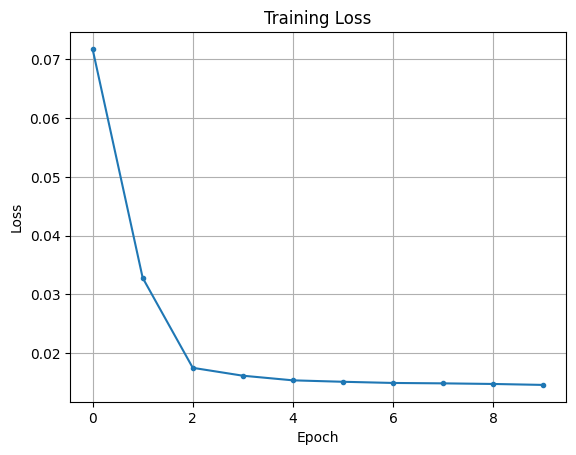

In [ ]:
# Plot loss
plt.plot(losses, '.-', label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.grid()
plt.show()

Test Loss: 0.014357


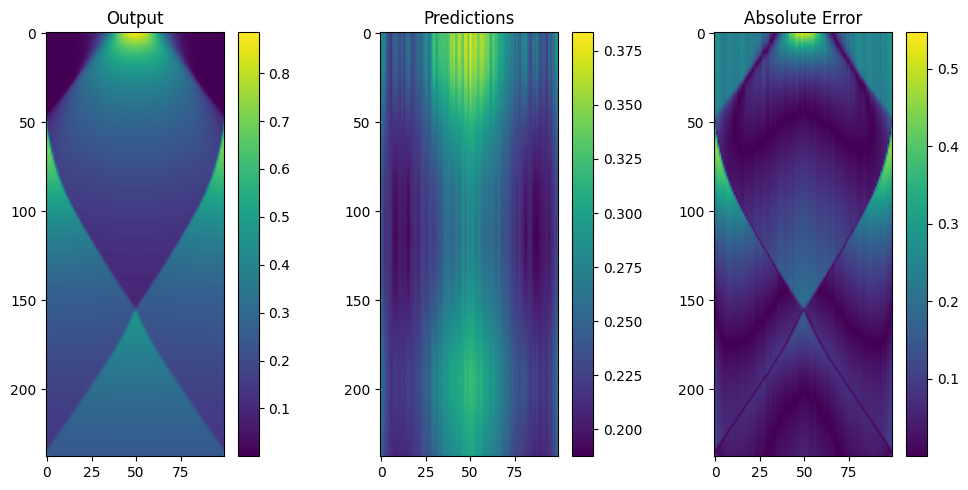

In [ ]:
model.eval()  # Set to evaluation mode
with torch.no_grad():  # Disable gradient computation
    predictions = model(X_input_tensor)  # Full dataset
    test_loss = loss_fn(predictions, X_output_tensor)
    print(f"Test Loss: {test_loss.item():.6f}")

# Plot the input, output, and predictions
plt.figure(figsize=(10, 5))

plt.subplot(1, 3, 1)
plt.imshow(X_output)
plt.colorbar()
plt.title('Output')

plt.subplot(1, 3, 2)
plt.imshow(predictions.numpy())
plt.colorbar()
plt.title('Predictions')

plt.subplot(1, 3, 3)
plt.imshow(np.abs(X_output - predictions.numpy()))
plt.colorbar()
plt.title('Absolute Error')

plt.tight_layout()
plt.show()
